In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
ticker_symbol = "AAPL"
stock_data = yf.download(ticker_symbol, start="2022-01-01", end="2024-01-01")
stock_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,177.830002,182.880005,177.710007,182.009995,179.481125,104487900
2022-01-04,182.630005,182.940002,179.119995,179.699997,177.203232,99310400
2022-01-05,179.610001,180.169998,174.639999,174.919998,172.489624,94537600
2022-01-06,172.699997,175.300003,171.639999,172.000000,169.610199,96904000
2022-01-07,172.889999,174.139999,171.029999,172.169998,169.777847,86709100
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542831,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.642548,48087700


In [3]:
stock_data['Simple Return'] = stock_data['Adj Close'].pct_change()
stock_data['Log Return'] = np.log(stock_data['Adj Close'] / stock_data['Adj Close'].shift(1))
stock_data['Realised Vol'] = stock_data['Log Return'].rolling(22).std()

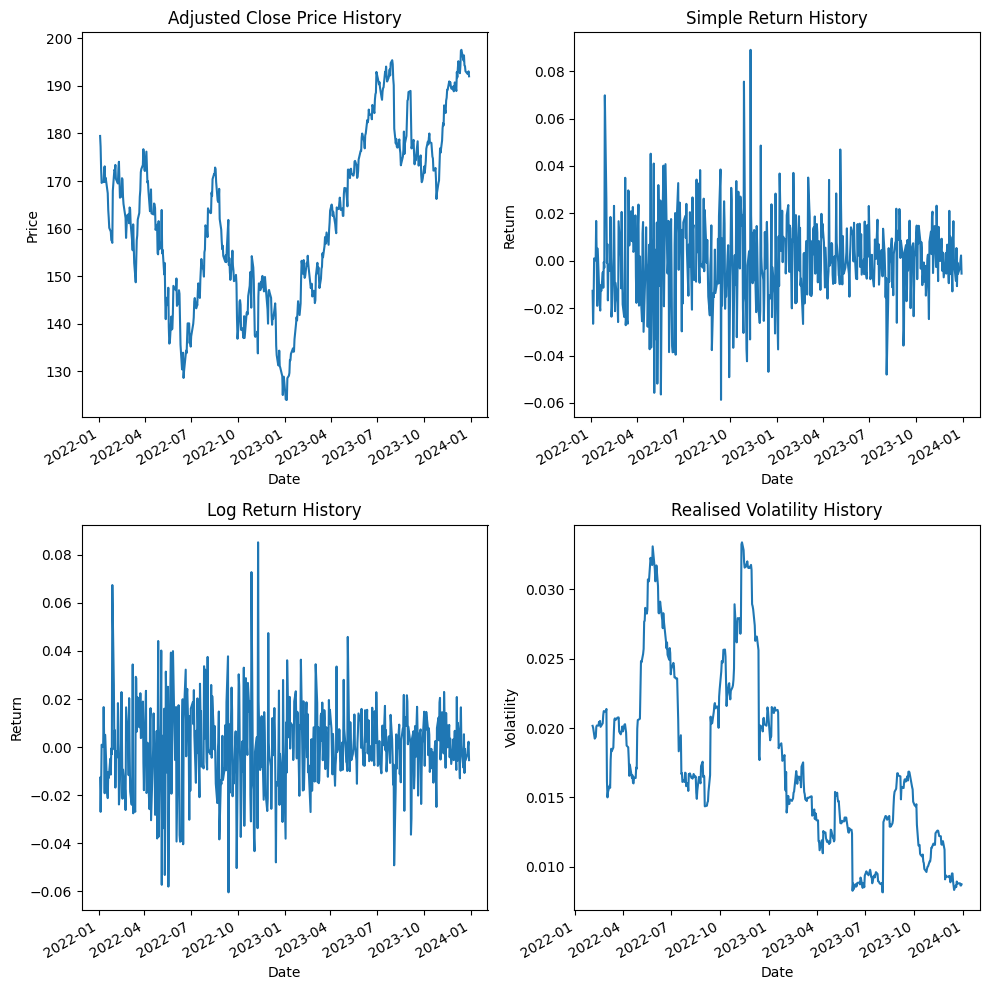

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
stock_data['Adj Close'].plot(ax=ax[0,0])
stock_data['Simple Return'].plot(ax=ax[0,1])
stock_data['Log Return'].plot(ax=ax[1,0])
stock_data['Realised Vol'].plot(ax=ax[1,1])

ax[0, 0].set_title("Adjusted Close Price History")
ax[0, 1].set_title("Simple Return History")
ax[1, 0].set_title("Log Return History")
ax[1, 1].set_title("Realised Volatility History")

ax[0, 0].set_ylabel("Price")
ax[0, 1].set_ylabel("Return")
ax[1, 0].set_ylabel("Return")
ax[1, 1].set_ylabel("Volatility")

plt.tight_layout()
plt.show()

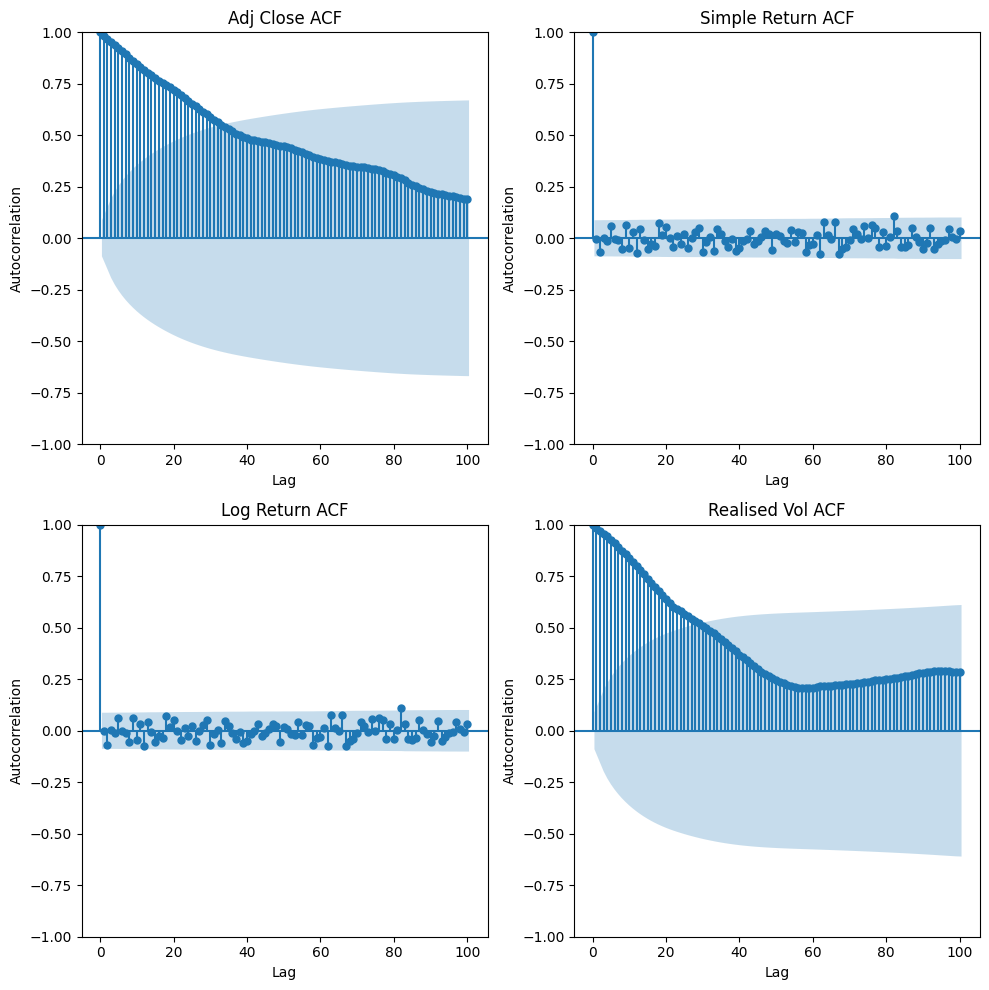

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

plot_acf(stock_data['Adj Close'], lags=100, ax=ax[0, 0])
plot_acf(stock_data['Simple Return'].dropna(), lags=100, ax=ax[0, 1])
plot_acf(stock_data['Log Return'].dropna(), lags=100, ax=ax[1, 0])
plot_acf(stock_data['Realised Vol'].dropna(), lags=100, ax=ax[1, 1])

ax[0, 0].set_title("Adj Close ACF")
ax[0, 0].set_xlabel("Lag")
ax[0, 0].set_ylabel("Autocorrelation")
ax[0, 1].set_title("Simple Return ACF")
ax[0, 1].set_xlabel("Lag")
ax[0, 1].set_ylabel("Autocorrelation")
ax[1, 0].set_title("Log Return ACF")
ax[1, 0].set_xlabel("Lag")
ax[1, 0].set_ylabel("Autocorrelation")
ax[1, 1].set_title("Realised Vol ACF")
ax[1, 1].set_xlabel("Lag")
ax[1, 1].set_ylabel("Autocorrelation")

plt.tight_layout()
plt.show()

In [6]:
from scipy.optimize import least_squares, minimize, LinearConstraint, NonlinearConstraint, BFGS, SR1
import scipy.optimize as scopt
import numpy as np
import matplotlib.pyplot as plt
from toy_datasets import ToyDatasets
from scipy.stats import norm
import jax.numpy as jnp
import jax.random as jrd
from jax import jit, value_and_grad, jacrev
import jax
from functools import partial
import pandas as pd
import yfinance as yf

In [7]:
class Stage6Algorithm():
  def __init__(self, num_features, ar_order):
    self.num_features, self.ar_order = num_features, ar_order
    self.X, self.G, self.S, self.K = None, None, None, None
    self.dims = None

  def objective(self, params):
    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, G, S = params[:X_len], params[X_len:X_len+G_len], params[X_len+G_len:X_len+G_len+S_len]
    X, G, S = X.reshape(X_shape), G.reshape(G_shape), S.reshape(S_shape)

    lg, ls, lx = 1, 1, 1
    objective_value = lg * np.linalg.norm(G) ** 2 + ls * np.linalg.norm(S, 1)

    return objective_value

  def hankel_constraint(self, params):
    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, K_t = params[:X_len], params[X_len+G_len+S_len:]
    X, K_t = X.reshape(X_shape), K_t.reshape(K_shape)
    K = self.K
    K[-self.num_features:] = K_t

    X1, X2 = X[:, :-1], X[:, 1:]
    X1, X2 = X1[:, self.idx_ravel].reshape(self.num_features * self.ar_order, -1), X2[:, self.idx_ravel].reshape(self.num_features * self.ar_order, -1)
    return (X2 - K @ X1).flatten()

  def D_constraint(self, params):
    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, G, S = params[:X_len], params[X_len:X_len+G_len], params[X_len+G_len:X_len+G_len+S_len]
    X, G, S = X.reshape(X_shape), G.reshape(G_shape), S.reshape(S_shape)
    return (self.D - X - G - S).flatten()
    
  def fit(self, D, bounds=None, retrain=False):
    if retrain:
      print("Using learned parameters")
      len_diff = D.shape[1] - self.X.shape[1]
      if len_diff == 0:
        X_initial_guess = self.X
      else:
        X_initial_guess = np.hstack((self.X, self.forecast(self.X, len_diff)))
      G_initial_guess, S_initial_guess, K_initial_guess = \
        np.hstack((self.G, np.zeros((D.shape[0], len_diff)))), np.hstack((self.S, np.zeros((D.shape[0], len_diff)))), self.K
    else:
      print("Learning from scratch")
      X_initial_guess, G_initial_guess, S_initial_guess, K_initial_guess = \
        D, np.random.normal(0, 0.01, D.shape), np.random.standard_t(3, D.shape) / 100, np.zeros((self.num_features, self.num_features*self.ar_order))

    min_val, max_val = D.min(axis=1).reshape(-1, 1), D.max(axis=1).reshape(-1, 1)
    self.min_val, self.max_val = min_val, max_val

    D = (D - min_val) / (max_val - min_val)
    X_initial_guess = (X_initial_guess - min_val) / (max_val - min_val)
    G_initial_guess = G_initial_guess / (max_val - min_val)
    S_initial_guess = S_initial_guess / (max_val - min_val)

    params = np.concatenate([X_initial_guess.flatten(), G_initial_guess.flatten(), S_initial_guess.flatten(), K_initial_guess.flatten()])
    dims = (
      (X_initial_guess.shape, len(X_initial_guess.flatten())),
      (G_initial_guess.shape, len(G_initial_guess.flatten())),
      (S_initial_guess.shape, len(S_initial_guess.flatten())),
      (K_initial_guess.shape, len(K_initial_guess.flatten()))
    )
    self.dims = dims

    self.D = D
    self.idx_ravel = (np.arange(self.ar_order)[:, None] + np.arange(D.shape[1] - self.ar_order)).ravel()

    K = np.zeros((self.num_features * self.ar_order, self.num_features * self.ar_order))
    rows, cols = np.diag_indices(self.num_features * self.ar_order - self.num_features)
    K[rows, cols + self.num_features] = 1
    self.K = K

    hankel_constraint = NonlinearConstraint(self.hankel_constraint, 0, 0)
    D_constraint = NonlinearConstraint(self.D_constraint, 0, 0)

    # constraints = (
    #   {'type': 'eq', 'fun': self.hankel_constraint, 'args': (K, dims[0][0], dims[0][1], dims[1][1], dims[2][1], dims[3][0], idx_ravel)},
    #   {'type': 'eq', 'fun': self.D_constraint, 'args': (D, dims[0][0], dims[0][1], dims[1][0], dims[1][1], dims[2][0], dims[2][1])},
    # )
    constraints = [hankel_constraint, D_constraint]

    options = {
      'disp': True,
      'maxiter': 1000,
      'gtol': 1e-6,
      'xtol': 1e-6
    }

    # obj_and_grad = jit(value_and_grad(self.objective))
    result = minimize(self.objective, params, method='trust-constr', constraints=constraints, options=options, jac='2-point', hess=BFGS())

    (X_shape, X_len), (G_shape, G_len), (S_shape, S_len), (K_shape, K_len) = self.dims
    X, G, S, K = result.x[:X_len], result.x[X_len:X_len+G_len], result.x[X_len+G_len:X_len+G_len+S_len], result.x[X_len+G_len+S_len:]
    X, G, S, K = X.reshape(X_shape), G.reshape(G_shape), S.reshape(S_shape), K.reshape(K_shape)

    X, G, S = X * (max_val - min_val) + min_val, G * (max_val - min_val), S * (max_val - min_val)
    self.X, self.G, self.S, self.K = X, G, S, K

  def forecast(self, x, timesteps):
    x = (x - self.min_val) / (self.max_val - self.min_val)
    current_window = x[:, -(self.ar_order+self.num_features)+1:]
    forecasted = np.zeros((self.num_features, timesteps))
    idx_ravel = (np.arange(self.ar_order)[:, None] + np.arange(current_window.shape[1] - self.ar_order + 1)).ravel()
    for i in range(timesteps):
      hankel_window = current_window[:, idx_ravel].reshape(self.num_features * self.ar_order, -1)
      next_el = (self.K @ hankel_window)[:, -1]
      forecasted[:, i] = next_el
      current_window = np.hstack((current_window, next_el.reshape(-1, 1)))[:, 1:]
    forecasted = forecasted * (self.max_val - self.min_val) + self.min_val
    return forecasted
  
  def evaluate(self, y, y_predicted):
    return np.sqrt(1/len(y) * np.sum(np.square(y - y_predicted)))

In [31]:
ticker_symbol = ["MSFT", "AAPL", "GOOG"]
stock_data = yf.download(ticker_symbol, period="2y")
stock_data

[*********************100%%**********************]  3 of 3 completed


Price        Adj Close                               Close              \
Ticker            AAPL        GOOG        MSFT        AAPL        GOOG   
Date                                                                     
2022-06-08  146.304733  117.237999  265.742371  147.960007  117.237999   
2022-06-09  141.044266  114.917999  260.219421  142.639999  114.917999   
2022-06-10  135.595947  111.427498  248.623077  137.130005  111.427498   
2022-06-13  130.404663  106.876503  238.078262  131.880005  106.876503   
2022-06-14  131.274796  107.194000  240.269791  132.759995  107.194000   
...                ...         ...         ...         ...         ...   
2024-06-03  194.029999  174.419998  413.519989  194.029999  174.419998   
2024-06-04  194.350006  175.130005  416.070007  194.350006  175.130005   
2024-06-05  195.869995  177.070007  424.010010  195.869995  177.070007   
2024-06-06  194.479996  178.350006  424.519989  194.479996  178.350006   
2024-06-07  196.889999  175.949997  423.850006  196.889999  175.949997   

Price                         High                                 Low  \
Ticker            MSFT        AAPL        GOOG        MSFT        AAPL   
Date                                                                     
2022-06-08  270.410004  149.869995  118.646004  273.000000  147.460007   
2022-06-09  264.790009  147.949997  118.349998  272.709991  142.529999   
2022-06-10  252.990005  140.759995  113.497002  260.579987  137.059998   
2022-06-13  242.259995  135.199997  109.218498  249.020004  131.440002   
2022-06-14  244.490005  133.889999  108.457497  245.740005  131.479996   
...                ...         ...         ...         ...         ...   
2024-06-03  413.519989  194.990005  175.860001  416.429993  192.520004   
2024-06-04  416.070007  195.320007  175.190002  416.440002  193.029999   
2024-06-05  424.010010  196.899994  177.970001  424.079987  194.869995   
2024-06-06  424.519989  196.500000  178.710007  425.309998  194.169998   
2024-06-07  423.850006  196.940002  179.419998  426.279999  194.139999   

Price                                     Open                          \
Ticker            GOOG        MSFT        AAPL        GOOG        MSFT   
Date                                                                     
2022-06-08  116.696747  269.609985  148.580002  116.876503  271.709991   
2022-06-09  114.866997  264.630005  147.080002  116.341499  267.779999   
2022-06-10  110.861000  252.529999  140.279999  112.781250  260.579987   
2022-06-13  106.588051  241.529999  132.869995  107.445999  245.110001   
2022-06-14  106.351997  241.509995  133.130005  106.889999  243.860001   
...                ...         ...         ...         ...         ...   
2024-06-03  172.449997  408.920013  192.899994  173.880005  415.529999   
2024-06-04  173.220001  409.679993  194.639999  174.449997  412.429993   
2024-06-05  175.289993  416.299988  195.399994  176.535004  417.809998   
2024-06-06  177.210007  420.579987  195.690002  177.429993  424.010010   
2024-06-07  175.789993  423.000000  194.649994  178.460007  426.200012   

Price          Volume                      
Ticker           AAPL      GOOG      MSFT  
Date                                       
2022-06-08   53950200  22544000  17372300  
2022-06-09   69473000  23142000  26439700  
2022-06-10   91437900  31324000  31422800  
2022-06-13  122207100  36756000  46135800  
2022-06-14   84784300  25480000  28651500  
...               ...       ...       ...  
2024-06-03   50080500  20742800  17484700  
2024-06-04   47471400  14066600  14348900  
2024-06-05   54156800  15233900  16988000  
2024-06-06   41181800  14255800  14861300  
2024-06-07   53044700  14690400  13611100  

[503 rows x 18 columns]

In [32]:
for ticker in ticker_symbol:
  stock_data['Simple Return', ticker] = stock_data['Adj Close', ticker].pct_change()
  stock_data['Log Return', ticker] = np.log(stock_data['Adj Close', ticker] / stock_data['Adj Close', ticker].shift(1))
  stock_data['Realised Vol', ticker] = stock_data['Log Return', ticker].rolling(22).std()

In [33]:
stock_data

Price        Adj Close                               Close              \
Ticker            AAPL        GOOG        MSFT        AAPL        GOOG   
Date                                                                     
2022-06-08  146.304733  117.237999  265.742371  147.960007  117.237999   
2022-06-09  141.044266  114.917999  260.219421  142.639999  114.917999   
2022-06-10  135.595947  111.427498  248.623077  137.130005  111.427498   
2022-06-13  130.404663  106.876503  238.078262  131.880005  106.876503   
2022-06-14  131.274796  107.194000  240.269791  132.759995  107.194000   
...                ...         ...         ...         ...         ...   
2024-06-03  194.029999  174.419998  413.519989  194.029999  174.419998   
2024-06-04  194.350006  175.130005  416.070007  194.350006  175.130005   
2024-06-05  195.869995  177.070007  424.010010  195.869995  177.070007   
2024-06-06  194.479996  178.350006  424.519989  194.479996  178.350006   
2024-06-07  196.889999  175.949997  423.850006  196.889999  175.949997   

Price                         High                                 Low  ...  \
Ticker            MSFT        AAPL        GOOG        MSFT        AAPL  ...   
Date                                                                    ...   
2022-06-08  270.410004  149.869995  118.646004  273.000000  147.460007  ...   
2022-06-09  264.790009  147.949997  118.349998  272.709991  142.529999  ...   
2022-06-10  252.990005  140.759995  113.497002  260.579987  137.059998  ...   
2022-06-13  242.259995  135.199997  109.218498  249.020004  131.440002  ...   
2022-06-14  244.490005  133.889999  108.457497  245.740005  131.479996  ...   
...                ...         ...         ...         ...         ...  ...   
2024-06-03  413.519989  194.990005  175.860001  416.429993  192.520004  ...   
2024-06-04  416.070007  195.320007  175.190002  416.440002  193.029999  ...   
2024-06-05  424.010010  196.899994  177.970001  424.079987  194.869995  ...   
2024-06-06  424.519989  196.500000  178.710007  425.309998  194.169998  ...   
2024-06-07  423.850006  196.940002  179.419998  426.279999  194.139999  ...   

Price         Volume Simple Return Log Return Realised Vol Simple Return  \
Ticker          MSFT          MSFT       MSFT         MSFT          AAPL   
Date                                                                       
2022-06-08  17372300           NaN        NaN          NaN           NaN   
2022-06-09  26439700     -0.020783  -0.021002          NaN     -0.035956   
2022-06-10  31422800     -0.044564  -0.045587          NaN     -0.038628   
2022-06-13  46135800     -0.042413  -0.043339          NaN     -0.038285   
2022-06-14  28651500      0.009205   0.009163          NaN      0.006673   
...              ...           ...        ...          ...           ...   
2024-06-03  17484700     -0.003878  -0.003886     0.011588      0.009259   
2024-06-04  14348900      0.006167   0.006148     0.011566      0.001649   
2024-06-05  16988000      0.019083   0.018904     0.011335      0.007821   
2024-06-06  14861300      0.001203   0.001202     0.010842     -0.007097   
2024-06-07  13611100     -0.001578  -0.001579     0.010560      0.012392   

Price      Log Return Realised Vol Simple Return Log Return Realised Vol  
Ticker           AAPL         AAPL          GOOG       GOOG         GOOG  
Date                                                                      
2022-06-08        NaN          NaN           NaN        NaN          NaN  
2022-06-09  -0.036618          NaN     -0.019789  -0.019987          NaN  
2022-06-10  -0.039394          NaN     -0.030374  -0.030845          NaN  
2022-06-13  -0.039037          NaN     -0.040843  -0.041700          NaN  
2022-06-14   0.006650          NaN      0.002971   0.002966          NaN  
...               ...          ...           ...        ...          ...  
2024-06-03   0.009216     0.015014      0.002644   0.002641     0.010159  
2024-06-04   0.001648     0.014631      0

In [34]:
stock_data['Adj Close'].dropna().to_numpy().shape

(503, 3)

Learning from scratch
`xtol` termination condition is satisfied.
Number of iterations: 192, function evaluations: 681014, CG iterations: 745, optimality: 4.56e-01, constraint violation: 2.86e-15, execution time: 1.7e+02 s.
Fit MSE:  124.67153928355853
Forecast MSE:  36.40619676920104
Learning from scratch
`xtol` termination condition is satisfied.
Number of iterations: 309, function evaluations: 1038233, CG iterations: 2119, optimality: 4.31e-01, constraint violation: 3.33e-16, execution time: 2.8e+02 s.
Fit MSE:  0.0676369087724966
Forecast MSE:  0.02198510948094871


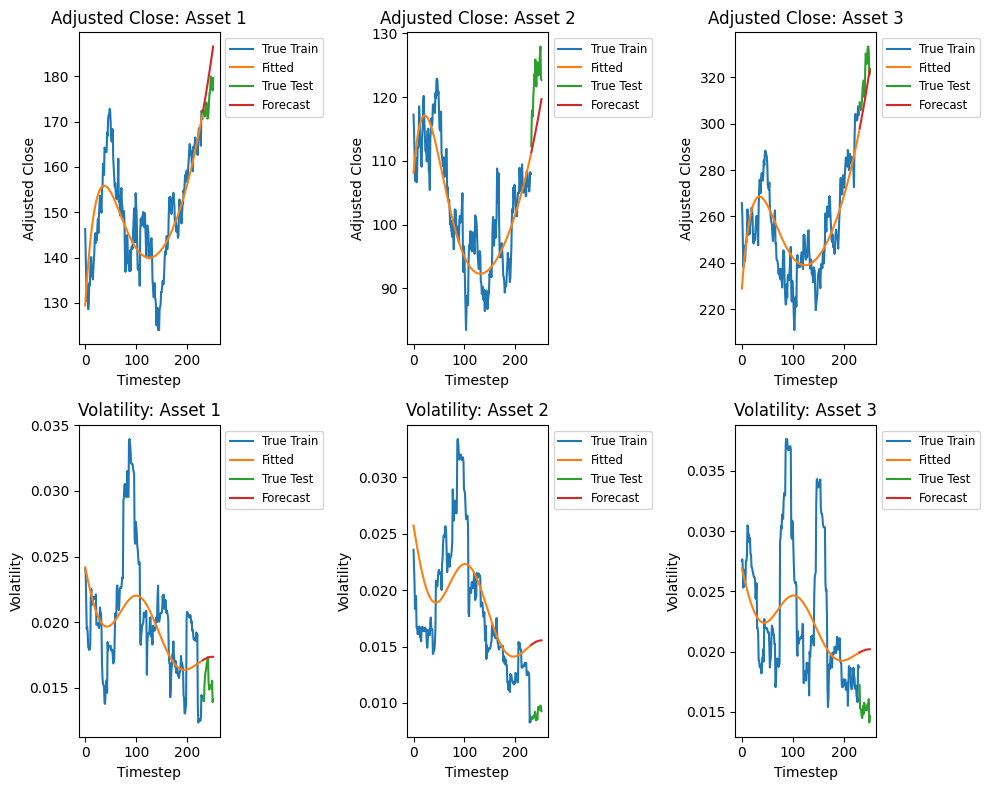

In [36]:
order, test_len = 1, 21

datasets = [
  ("Adjusted Close", stock_data['Adj Close'].dropna().to_numpy()[:252].T),
  ("Volatility", stock_data['Realised Vol'].dropna().to_numpy()[:252].T),
]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))

for i, (title, ds) in enumerate(datasets):
  train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

  alg = Stage6Algorithm(num_features=train_data.shape[0], ar_order=order)
  alg.fit(train_data)
  fitted = alg.X
  forecasted = alg.forecast(fitted, test_len)
  ax[i % 2, 0].plot(range(train_data.shape[1]), train_data[0], label="True Train")
  ax[i % 2, 1].plot(range(train_data.shape[1]), train_data[1], label="True Train")
  ax[i % 2, 2].plot(range(train_data.shape[1]), train_data[2], label="True Train")

  ax[i % 2, 0].plot(range(train_data.shape[1]), fitted[0], label="Fitted")
  ax[i % 2, 1].plot(range(train_data.shape[1]), fitted[1], label="Fitted")
  ax[i % 2, 2].plot(range(train_data.shape[1]), fitted[2], label="Fitted")

  ax[i % 2, 0].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data[0], label="True Test")
  ax[i % 2, 1].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data[1], label="True Test")
  ax[i % 2, 2].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data[2], label="True Test")

  ax[i % 2, 0].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted[0], label="Forecast")
  ax[i % 2, 1].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted[1], label="Forecast")
  ax[i % 2, 2].plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted[2], label="Forecast")

  ax[i % 2, 0].set_xlabel("Timestep")
  ax[i % 2, 1].set_xlabel("Timestep")
  ax[i % 2, 2].set_xlabel("Timestep")

  ax[i % 2, 0].set_ylabel(title)
  ax[i % 2, 1].set_ylabel(title)
  ax[i % 2, 2].set_ylabel(title)

  ax[i % 2, 0].set_title(f"{title}: Asset 1")
  ax[i % 2, 1].set_title(f"{title}: Asset 2")
  ax[i % 2, 2].set_title(f"{title}: Asset 3")

  ax[i % 2, 0].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
  ax[i % 2, 1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
  ax[i % 2, 2].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

  fit_mse = alg.evaluate(train_data, alg.X)
  print("Fit MSE: ", fit_mse)
  forecast_mse = alg.evaluate(test_data, forecasted)
  print("Forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

In [49]:
ticker_symbol = ["AML.L"]
stock_data = yf.download(ticker_symbol, period="2y")
stock_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-07,255.763000,256.207794,247.305801,251.166702,251.166702,1371612
2022-06-08,246.125595,257.468109,244.817505,256.133698,256.133698,545980
2022-06-09,253.168304,255.837097,242.863602,242.863602,242.863602,715159
2022-06-10,247.682404,247.682404,223.292206,226.776505,226.776505,1426998
2022-06-13,222.402603,225.506195,198.383102,200.162292,200.162292,2355433
...,...,...,...,...,...,...
2024-06-03,147.199997,154.699997,146.100006,148.800003,148.800003,2394095
2024-06-04,148.500000,150.199997,146.699997,146.699997,146.699997,1294261
2024-06-05,148.399994,158.699997,147.300003,157.000000,157.000000,3192519


In [50]:
stock_data['Adj Close'].dropna().to_numpy().reshape(1, -1).shape

(1, 506)

In [52]:
order, test_len = 21, 21

datasets = [
  ("Adjusted Close", stock_data['Adj Close'].dropna().to_numpy().reshape(1, -1)),
]

title, ds = datasets[0]
train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

alg = Stage6Algorithm(num_features=train_data.shape[0], ar_order=order)
alg.fit(train_data)
fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data[0], label="True Train")
plt.plot(range(train_data.shape[1]), fitted[0], label="Fitted")

plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data[0], label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted[0], label="Forecast")

plt.xlabel("Timestep")

plt.ylabel(title)

plt.title(f"{title}")

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

fit_mse = alg.evaluate(train_data, alg.X)
print("Fit MSE: ", fit_mse)
forecast_mse = alg.evaluate(test_data, forecasted)
print("Forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

Learning from scratch


/vol/bitbucket/cm1220/fyp/venv/lib/python3.10/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py:80: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
/vol/bitbucket/cm1220/fyp/venv/lib/python3.10/site-packages/scipy/optimize/_trustregion_constr/equality_constrained_sqp.py:203: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
/vol/bitbucket/cm1220/fyp/venv/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


KeyboardInterrupt: 

Learning from scratch


c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:80: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:203: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


`xtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 30712, CG iterations: 0, optimality: 1.89e+00, constraint violation: 3.33e-16, execution time: 1.3e+02 s.
Fit MSE:  0.09212860633052772
Forecast MSE:  0.01874294192157292


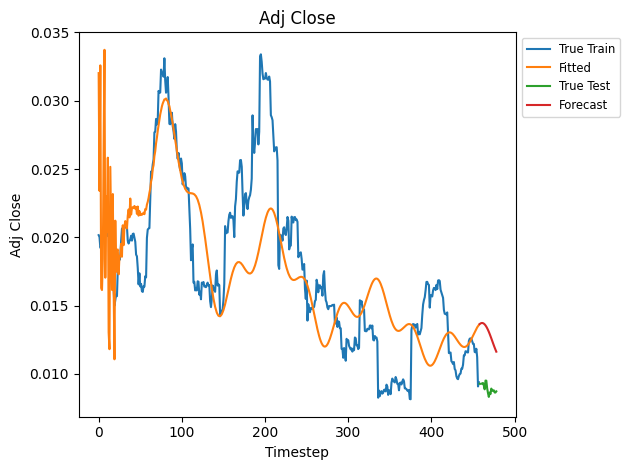

In [28]:
order, test_len = 21, 21
ds = stock_data['Realised Vol'].dropna().to_numpy().reshape(1, -1)
train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

alg = Stage6Algorithm(num_features=train_data.shape[0], ar_order=order)
alg.fit(train_data)
fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.xlabel("Timestep")
plt.ylabel("Adj Close")
plt.title("Adj Close")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

fit_mse = alg.evaluate(train_data, alg.X)
print("Fit MSE: ", fit_mse)
forecast_mse = alg.evaluate(test_data, forecasted)
print("Forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

Learning from scratch
`xtol` termination condition is satisfied.
Number of iterations: 18, function evaluations: 16049, CG iterations: 0, optimality: 9.50e-01, constraint violation: 2.22e-16, execution time: 7.9e+01 s.
Fit MSE:  0.3971994041604639
Forecast MSE:  0.03985448113090678


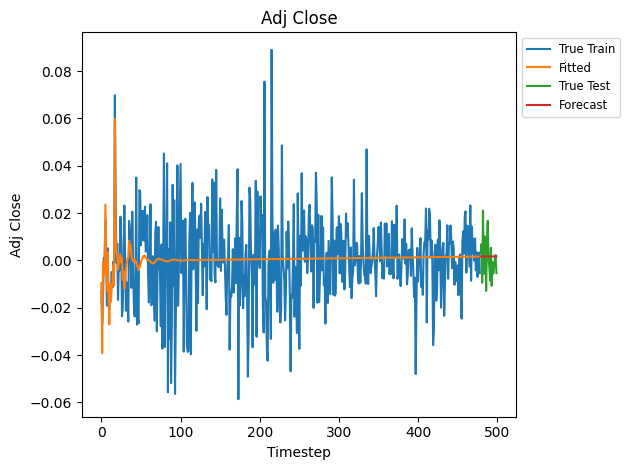

In [29]:
order, test_len = 21, 21
ds = stock_data['Simple Return'].dropna().to_numpy().reshape(1, -1)
train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

alg = Stage6Algorithm(num_features=train_data.shape[0], ar_order=order)
alg.fit(train_data)
fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.xlabel("Timestep")
plt.ylabel("Adj Close")
plt.title("Adj Close")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

fit_mse = alg.evaluate(train_data, alg.X)
print("Fit MSE: ", fit_mse)
forecast_mse = alg.evaluate(test_data, forecasted)
print("Forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

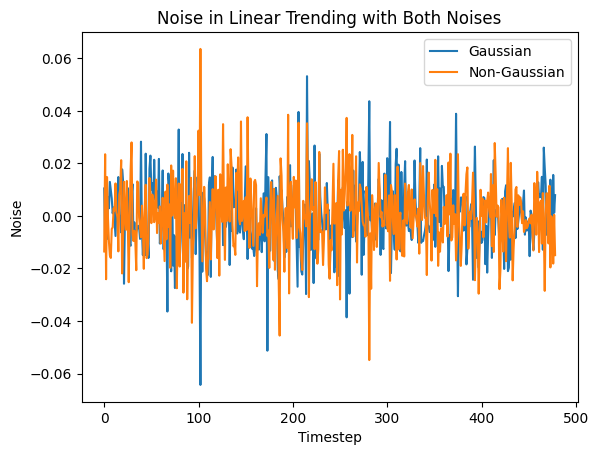

In [31]:
plt.plot(alg.G.T, label="Gaussian")
plt.plot(alg.S.T, label="Non-Gaussian")
plt.title("Noise in Linear Trending with Both Noises")
plt.xlabel("Timestep")
plt.ylabel("Noise")
plt.legend()
plt.show()

In [32]:
order, test_len = 1, 21
ds = stock_data['Simple Return'].dropna().to_numpy().reshape(1, -1)
train_data, test_data = ds[:, :ds.shape[1]-test_len], ds[:, ds.shape[1]-test_len:]

alg = Stage6Algorithm(num_features=train_data.shape[0], ar_order=order)
alg.fit(train_data)
fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.T, label="True Train")
plt.plot(range(train_data.shape[1]), fitted.T, label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.T, label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted.T, label="Forecast")
plt.xlabel("Timestep")
plt.ylabel("Adj Close")
plt.title("Adj Close")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

fit_mse = alg.evaluate(train_data, alg.X)
print("Fit MSE: ", fit_mse)
forecast_mse = alg.evaluate(test_data, forecasted)
print("Forecast MSE: ", forecast_mse)

plt.tight_layout()
plt.show()

Learning from scratch


c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


KeyboardInterrupt: 